# 08 — Multi-Task Tuning v2: Lambda & Phase Experiments

Notebook ini menjalankan **4 skenario** training multi-task dengan konfigurasi berbeda untuk mencari setting optimal.

**Hipotesis**: λ1=λ2=0.3 (paper default) terlalu besar untuk dataset kecil (2,451 sampel). Auxiliary losses mendominasi gradient → multi-task kalah dari single-task.

| Skenario | λ1 | λ2 | Phase 1 | Phase 2 | Total Epochs | Catatan |
|---|---|---|---|---|---|---|
| **A** | 0.1 | 0.1 | 3 | 15 | 18 | Lower auxiliary weight |
| **B** | 0.05 | 0.05 | 3 | 15 | 18 | Minimal auxiliary weight |
| **C** | 0.1 | 0.1 | 0 | 18 | 18 | No Phase 1, no Sent. Connection |
| **D** | 0.1 | 0.1 | 3 | 22 | 25 | More epochs (patience=7) |

**Base settings** (identik NB 03): Dropout=0.1, WD=0.01, No freeze, LR BERT=2e-5, LR Head=1e-4

**Target**: Beat single-task F1 = **0.7551** (NB 07)

In [1]:
import json
import os
import string
import time
import gc
from collections import Counter
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from torchcrf import CRF
from seqeval.metrics import classification_report, f1_score as seq_f1_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'PyTorch: {torch.__version__}')
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')

PyTorch: 2.5.1+cu121
Device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
VRAM: 8.0 GB


### 1. KONFIGURASI

In [2]:
# Paths
BASE_DIR = os.path.dirname(os.getcwd())
DATA_RAW_DIR = os.path.join(BASE_DIR, 'data', 'raw')
DATA_PROC_DIR = os.path.join(BASE_DIR, 'data', 'processed')
MODEL_DIR = os.path.join(BASE_DIR, 'models')
os.makedirs(MODEL_DIR, exist_ok=True)

BIEOS_PATH = os.path.join(DATA_PROC_DIR, 'train_data_bieos.json')
POS_LEX_PATH = os.path.join(DATA_RAW_DIR, 'indonesian_sentiment_lexicon_positive.tsv')
NEG_LEX_PATH = os.path.join(DATA_RAW_DIR, 'indonesian_sentiment_lexicon_negative.tsv')

# Model
MODEL_NAME = 'indobenchmark/indobert-large-p2'
MAX_LENGTH = 128
PROJ_DIM = 256

# Base training config (sama dengan NB 03)
BATCH_SIZE = 4
GRADIENT_ACCUMULATION = 4
LR_BERT = 2e-5
LR_HEAD = 1e-4
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01
MAX_GRAD_NORM = 1.0
TRAIN_RATIO = 0.85
SEED = 42
DROPOUT = 0.1
MAX_REL_POS = 20
IGNORE_INDEX = -100

# ============================================================
# SKENARIO DEFINITIONS
# ============================================================
SCENARIOS = [
    {
        'name': 'A: Low Lambda (0.1)',
        'lambda1': 0.1,
        'lambda2': 0.1,
        'phase1_epochs': 3,
        'phase2_epochs': 15,
        'patience': 5,
    },
    {
        'name': 'B: Very Low Lambda (0.05)',
        'lambda1': 0.05,
        'lambda2': 0.05,
        'phase1_epochs': 3,
        'phase2_epochs': 15,
        'patience': 5,
    },
    {
        'name': 'C: No Phase 1 (λ=0.1)',
        'lambda1': 0.1,
        'lambda2': 0.1,
        'phase1_epochs': 0,
        'phase2_epochs': 18,
        'patience': 5,
    },
    {
        'name': 'D: Low Lambda + 25 Epochs',
        'lambda1': 0.1,
        'lambda2': 0.1,
        'phase1_epochs': 3,
        'phase2_epochs': 22,
        'patience': 7,
    },
]

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f'Total skenario: {len(SCENARIOS)}')
for i, s in enumerate(SCENARIOS):
    total_ep = s['phase1_epochs'] + s['phase2_epochs']
    print(f"  {s['name']:30s} | λ1={s['lambda1']}, λ2={s['lambda2']} | "
          f"P1={s['phase1_epochs']}, P2={s['phase2_epochs']} ({total_ep} total) | pat={s['patience']}")

Total skenario: 4
  A: Low Lambda (0.1)            | λ1=0.1, λ2=0.1 | P1=3, P2=15 (18 total) | pat=5
  B: Very Low Lambda (0.05)      | λ1=0.05, λ2=0.05 | P1=3, P2=15 (18 total) | pat=5
  C: No Phase 1 (λ=0.1)          | λ1=0.1, λ2=0.1 | P1=0, P2=18 (18 total) | pat=5
  D: Low Lambda + 25 Epochs      | λ1=0.1, λ2=0.1 | P1=3, P2=22 (25 total) | pat=7


### 2. LOAD DATA

In [3]:
with open(BIEOS_PATH, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)
print(f'Total data: {len(raw_data)}')

def load_lexicon(path):
    words = set()
    with open(path, 'r', encoding='utf-8') as f:
        next(f)
        for line in f:
            parts = line.strip().split('\t')
            if parts:
                word = parts[0].strip().lower()
                if ' ' not in word and len(word) > 1:
                    words.add(word)
    return words

pos_lexicon = load_lexicon(POS_LEX_PATH)
neg_lexicon = load_lexicon(NEG_LEX_PATH)
overlap = pos_lexicon & neg_lexicon
pos_lexicon -= overlap
neg_lexicon -= overlap

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f'Positive lexicon: {len(pos_lexicon)}')
print(f'Negative lexicon: {len(neg_lexicon)}')
print(f'Tokenizer loaded: {MODEL_NAME}')

Total data: 2451


Positive lexicon: 2288
Negative lexicon: 5025
Tokenizer loaded: indobenchmark/indobert-large-p2


### 3. LABEL PREPARATION

In [4]:
ate_labels = ['O', 'B', 'I', 'E', 'S']
sld_labels = ['O', 'POS', 'NEG']
asd_labels = ['O', 'POS', 'NEG', 'NEU']
bieos_labels = ['O', 'B-NEG', 'B-NEU', 'B-POS', 'E-NEG', 'E-NEU', 'E-POS',
                'I-NEG', 'I-NEU', 'I-POS', 'S-NEG', 'S-NEU', 'S-POS']

ate_label2id = {l: i for i, l in enumerate(ate_labels)}
sld_label2id = {l: i for i, l in enumerate(sld_labels)}
asd_label2id = {l: i for i, l in enumerate(asd_labels)}
bieos_label2id = {l: i for i, l in enumerate(bieos_labels)}
bieos_id2label = {i: l for l, i in bieos_label2id.items()}

# Prior Embedding
word_ate_freq = {}
for d in raw_data:
    for tok, lab in zip(d['tokens'], d['labels']):
        tok_lower = tok.lower()
        if tok_lower not in word_ate_freq:
            word_ate_freq[tok_lower] = [0] * len(ate_labels)
        if lab == 'O':
            word_ate_freq[tok_lower][ate_label2id['O']] += 1
        else:
            prefix = lab.split('-')[0]
            word_ate_freq[tok_lower][ate_label2id[prefix]] += 1

default_prior = [1.0] + [0.0] * (len(ate_labels) - 1)
word_prior = {}
for word, counts in word_ate_freq.items():
    total = sum(counts)
    word_prior[word] = [c / total for c in counts] if total > 0 else default_prior

# Prepare aligned labels
all_input_ids, all_attention_mask = [], []
all_ate, all_sld, all_asd, all_bieos, all_crf, all_prior = [], [], [], [], [], []

for d in tqdm(raw_data, desc='Preparing labels'):
    tokens, labels = d['tokens'], d['labels']
    enc = tokenizer(tokens, is_split_into_words=True,
                    max_length=MAX_LENGTH, padding='max_length',
                    truncation=True, return_tensors='pt')
    word_ids = enc.word_ids(batch_index=0)

    ate_w, sld_w, asd_w = [], [], []
    for tok, lab in zip(tokens, labels):
        if lab == 'O':
            ate_w.append('O'); asd_w.append('O')
        else:
            prefix, sentiment = lab.split('-', 1)
            ate_w.append(prefix); asd_w.append(sentiment)
        t_clean = tok.lower().strip(string.punctuation)
        if t_clean in pos_lexicon:
            sld_w.append('POS')
        elif t_clean in neg_lexicon:
            sld_w.append('NEG')
        else:
            sld_w.append('O')

    ate_a, sld_a, asd_a, bieos_a, crf_a, prior_a = [], [], [], [], [], []
    prev_wid = None
    for wid in word_ids:
        if wid is None:
            ate_a.append(IGNORE_INDEX); sld_a.append(IGNORE_INDEX)
            asd_a.append(IGNORE_INDEX); bieos_a.append(IGNORE_INDEX)
            crf_a.append(0); prior_a.append(default_prior)
        elif wid != prev_wid:
            if wid < len(tokens):
                ate_a.append(ate_label2id[ate_w[wid]])
                sld_a.append(sld_label2id[sld_w[wid]])
                asd_a.append(asd_label2id[asd_w[wid]])
                bieos_a.append(bieos_label2id[labels[wid]])
                crf_a.append(bieos_label2id[labels[wid]])
                prior_a.append(word_prior.get(tokens[wid].lower(), default_prior))
            else:
                ate_a.append(IGNORE_INDEX); sld_a.append(IGNORE_INDEX)
                asd_a.append(IGNORE_INDEX); bieos_a.append(IGNORE_INDEX)
                crf_a.append(0); prior_a.append(default_prior)
        else:
            ate_a.append(IGNORE_INDEX); sld_a.append(IGNORE_INDEX)
            asd_a.append(IGNORE_INDEX); bieos_a.append(IGNORE_INDEX)
            crf_a.append(bieos_label2id[labels[wid]] if wid < len(tokens) else 0)
            prior_a.append(word_prior.get(tokens[wid].lower(), default_prior) if wid < len(tokens) else default_prior)
        prev_wid = wid

    all_input_ids.append(enc['input_ids'].squeeze(0))
    all_attention_mask.append(enc['attention_mask'].squeeze(0))
    all_ate.append(torch.tensor(ate_a, dtype=torch.long))
    all_sld.append(torch.tensor(sld_a, dtype=torch.long))
    all_asd.append(torch.tensor(asd_a, dtype=torch.long))
    all_bieos.append(torch.tensor(bieos_a, dtype=torch.long))
    all_crf.append(torch.tensor(crf_a, dtype=torch.long))
    all_prior.append(torch.tensor(prior_a, dtype=torch.float))

data_dict = {
    'input_ids': torch.stack(all_input_ids),
    'attention_mask': torch.stack(all_attention_mask),
    'ate_labels': torch.stack(all_ate),
    'sld_labels': torch.stack(all_sld),
    'asd_labels': torch.stack(all_asd),
    'bieos_labels': torch.stack(all_bieos),
    'crf_labels': torch.stack(all_crf),
    'prior_probs': torch.stack(all_prior),
}

print('\nDataset shapes:')
for k, v in data_dict.items():
    print(f'  {k}: {v.shape}')

Preparing labels:   0%|          | 0/2451 [00:00<?, ?it/s]


Dataset shapes:
  input_ids: torch.Size([2451, 128])
  attention_mask: torch.Size([2451, 128])
  ate_labels: torch.Size([2451, 128])
  sld_labels: torch.Size([2451, 128])
  asd_labels: torch.Size([2451, 128])
  bieos_labels: torch.Size([2451, 128])
  crf_labels: torch.Size([2451, 128])
  prior_probs: torch.Size([2451, 128, 5])


### 4. DATASET & SPLIT

In [5]:
class ABSAMultiTaskDataset(Dataset):
    def __init__(self, data_dict, indices):
        self.data = {k: v[indices] for k, v in data_dict.items()}

    def __len__(self):
        return self.data['input_ids'].size(0)

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}

total = len(raw_data)
indices = torch.randperm(total, generator=torch.Generator().manual_seed(SEED))
split = int(total * TRAIN_RATIO)

train_dataset = ABSAMultiTaskDataset(data_dict, indices[:split])
val_dataset = ABSAMultiTaskDataset(data_dict, indices[split:])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE * 2)

print(f'Train: {len(train_dataset)} ({TRAIN_RATIO*100:.0f}%)')
print(f'Val  : {len(val_dataset)} ({(1-TRAIN_RATIO)*100:.0f}%)')
print(f'Train batches: {len(train_loader)}')

Train: 2083 (85%)
Val  : 368 (15%)
Train batches: 521


### 5. MODEL (sama dengan NB 03)

In [6]:
class CrossAttentionASD(nn.Module):
    def __init__(self, dim, max_relative_position=20):
        super().__init__()
        self.max_rel_pos = max_relative_position
        self.pos_embedding = nn.Embedding(2 * max_relative_position + 1, dim)
        self.W_ae = nn.Linear(dim, dim, bias=False)
        self.W_sl = nn.Linear(dim, dim, bias=False)
        self.W_pos = nn.Linear(dim, dim, bias=False)
        self.bias = nn.Parameter(torch.zeros(dim))
        self.w_s = nn.Linear(dim, 1, bias=False)

    def forward(self, h_ae, h_sl, mask=None):
        batch, seq_len, dim = h_ae.shape
        pos = torch.arange(seq_len, device=h_ae.device)
        rel_pos = (pos.unsqueeze(0) - pos.unsqueeze(1)).clamp(
            -self.max_rel_pos, self.max_rel_pos) + self.max_rel_pos
        p_ij = self.pos_embedding(rel_pos)
        s_ae = self.W_ae(h_ae)
        s_sl = self.W_sl(h_sl)
        s_pos = self.W_pos(p_ij)
        combined = s_ae.unsqueeze(2) + s_sl.unsqueeze(1) + s_pos.unsqueeze(0) + self.bias
        scores = self.w_s(torch.tanh(combined)).squeeze(-1)
        if mask is not None:
            scores = scores.masked_fill(~mask.unsqueeze(1), float('-inf'))
        attn_weights = torch.softmax(scores, dim=-1)
        h_sd = torch.bmm(attn_weights, h_sl)
        return h_sd


class HierarchicalMultiTaskABSA(nn.Module):
    def __init__(self, model_name, num_ate, num_sld, num_asd, num_final,
                 proj_dim=256, dropout=0.1, asd_weights=None,
                 max_relative_position=20, lambda1=0.3, lambda2=0.3):
        super().__init__()
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.num_sld = num_sld
        self.num_asd = num_asd

        self.bert = AutoModel.from_pretrained(model_name, use_safetensors=True, low_cpu_mem_usage=True)
        bert_dim = self.bert.config.hidden_size

        self.ate_proj = nn.Sequential(
            nn.Linear(bert_dim + num_ate, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.ate_classifier = nn.Linear(proj_dim, num_ate)

        self.sld_proj = nn.Sequential(
            nn.Linear(bert_dim, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.sld_classifier = nn.Linear(proj_dim, num_sld)

        self.cross_attention = CrossAttentionASD(proj_dim, max_relative_position)
        self.asd_classifier = nn.Linear(proj_dim, num_asd)

        self.final_proj = nn.Sequential(
            nn.Linear(proj_dim * 2, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.final_emission = nn.Linear(proj_dim, num_final)
        self.crf = CRF(num_final, batch_first=True)

        self.dropout = nn.Dropout(dropout)
        self.asd_weights = asd_weights

    def forward(self, input_ids, attention_mask, prior_probs=None,
                ate_labels=None, sld_labels=None, asd_labels=None, crf_labels=None, **kwargs):
        h = self.dropout(self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state)

        if prior_probs is not None:
            h_with_prior = torch.cat([h, prior_probs], dim=-1)
        else:
            h_with_prior = torch.cat([h, torch.zeros(*h.shape[:-1], self.ate_classifier.out_features, device=h.device)], dim=-1)
        h_ae = self.ate_proj(h_with_prior)
        ate_logits = self.ate_classifier(h_ae)

        h_sl = self.sld_proj(h)
        sld_logits = self.sld_classifier(h_sl)

        mask = attention_mask.bool()
        h_sd = self.cross_attention(h_ae, h_sl, mask=mask)
        asd_logits = self.asd_classifier(h_sd)

        h_concat = torch.cat([h_ae, h_sd], dim=-1)
        emissions = self.final_emission(self.final_proj(h_concat))

        outputs = {'ate_logits': ate_logits, 'sld_logits': sld_logits,
                   'asd_logits': asd_logits, 'emissions': emissions}

        if ate_labels is not None:
            ce = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
            loss_ate = ce(ate_logits.view(-1, ate_logits.size(-1)), ate_labels.view(-1))
            loss_sld = ce(sld_logits.view(-1, sld_logits.size(-1)), sld_labels.view(-1))
            ce_asd = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX,
                                          weight=self.asd_weights) if self.asd_weights is not None else ce
            loss_asd = ce_asd(asd_logits.view(-1, asd_logits.size(-1)), asd_labels.view(-1))
            loss_crf = -self.crf(emissions.float(), crf_labels, mask=mask, reduction='mean')

            outputs['loss'] = self.lambda1 * (loss_ate + loss_sld) + self.lambda2 * loss_asd + loss_crf
            outputs['losses'] = {
                'ate': loss_ate.detach(), 'sld': loss_sld.detach(),
                'asd': loss_asd.detach(), 'crf': loss_crf.detach()}

        return outputs

    def decode(self, emissions, attention_mask):
        return self.crf.decode(emissions.float(), mask=attention_mask.bool())

    def apply_sentiment_connection(self):
        with torch.no_grad():
            n_copy = min(self.num_sld, self.num_asd)
            self.asd_classifier.weight.data[:n_copy].copy_(self.sld_classifier.weight.data[:n_copy])
            self.asd_classifier.bias.data[:n_copy].copy_(self.sld_classifier.bias.data[:n_copy])
        print(f'  Sentiment Connection: copied SLD -> ASD (classes 0-{n_copy-1})')

print('Model class defined.')

Model class defined.


### 6. TRAINING INFRASTRUCTURE

In [7]:
def evaluate(model, dataloader, device, desc='Evaluating'):
    model.eval()
    total_loss = 0
    all_preds, all_true = [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=desc, leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            total_loss += outputs['loss'].item()
            preds = model.decode(outputs['emissions'], batch['attention_mask'])
            bieos_lbl = batch['bieos_labels']
            for i in range(len(preds)):
                pred_seq, true_seq = [], []
                for j in range(len(preds[i])):
                    if bieos_lbl[i][j].item() != IGNORE_INDEX:
                        pred_seq.append(bieos_id2label[preds[i][j]])
                        true_seq.append(bieos_id2label[bieos_lbl[i][j].item()])
                all_preds.append(pred_seq)
                all_true.append(true_seq)
    avg_loss = total_loss / len(dataloader)
    f1 = seq_f1_score(all_true, all_preds)
    return avg_loss, f1, all_true, all_preds


def train_one_epoch(model, train_loader, optimizer, scheduler, device, epoch_str):
    model.train()
    epoch_loss = 0
    epoch_comp = {'ate': 0, 'sld': 0, 'asd': 0, 'crf': 0}
    optimizer.zero_grad()
    step_bar = tqdm(train_loader, desc=epoch_str, leave=False, unit='batch')
    for step, batch in enumerate(step_bar):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs['loss'] / GRADIENT_ACCUMULATION
        loss.backward()
        if (step + 1) % GRADIENT_ACCUMULATION == 0 or (step + 1) == len(train_loader):
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        epoch_loss += outputs['loss'].item()
        for k in epoch_comp:
            epoch_comp[k] += outputs['losses'][k].item()
        step_bar.set_postfix(loss=f"{epoch_loss/(step+1):.3f}")
    n = len(train_loader)
    return epoch_loss / n, {k: v / n for k, v in epoch_comp.items()}


def run_scenario(scenario, train_loader, val_loader, device):
    """Run a complete training scenario. Returns results dict."""
    name = scenario['name']
    lambda1 = scenario['lambda1']
    lambda2 = scenario['lambda2']
    phase1_epochs = scenario['phase1_epochs']
    phase2_epochs = scenario['phase2_epochs']
    patience = scenario['patience']
    total_epochs = phase1_epochs + phase2_epochs

    print(f'\n{"="*60}')
    print(f'SCENARIO: {name}')
    print(f'  λ1={lambda1}, λ2={lambda2}, Phase1={phase1_epochs}, Phase2={phase2_epochs}, patience={patience}')
    print(f'  Start: {datetime.now().strftime("%H:%M:%S")}')
    print(f'{"="*60}')

    # Re-seed for reproducibility
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    # Init model
    model = HierarchicalMultiTaskABSA(
        model_name=MODEL_NAME,
        num_ate=len(ate_labels),
        num_sld=len(sld_labels),
        num_asd=len(asd_labels),
        num_final=len(bieos_labels),
        proj_dim=PROJ_DIM,
        dropout=DROPOUT,
        max_relative_position=MAX_REL_POS,
        lambda1=lambda1,
        lambda2=lambda2,
    ).to(device)

    # Optimizer
    bert_params = list(model.bert.named_parameters())
    head_params = [(n, p) for n, p in model.named_parameters() if not n.startswith('bert')]

    total_steps = (len(train_loader) // GRADIENT_ACCUMULATION) * total_epochs
    warmup_steps = int(total_steps * WARMUP_RATIO)

    optimizer = torch.optim.AdamW([
        {'params': [p for _, p in bert_params], 'lr': LR_BERT},
        {'params': [p for _, p in head_params], 'lr': LR_HEAD},
    ], weight_decay=WEIGHT_DECAY)

    scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    history = {'train_loss': [], 'val_loss': [], 'val_f1': [],
               'loss_ate': [], 'loss_sld': [], 'loss_asd': [], 'loss_crf': []}

    best_f1 = 0
    best_epoch = 0
    patience_counter = 0
    best_state = None
    t_start = time.time()

    # ---- PHASE 1 ----
    if phase1_epochs > 0:
        print(f'\n  Phase 1: Pre-training ({phase1_epochs} epochs)')
        for epoch in range(phase1_epochs):
            avg_train, comp = train_one_epoch(
                model, train_loader, optimizer, scheduler, device,
                f'  P1 {epoch+1}/{phase1_epochs}')
            val_loss, val_f1, _, _ = evaluate(model, val_loader, device)

            history['train_loss'].append(avg_train)
            history['val_loss'].append(val_loss)
            history['val_f1'].append(val_f1)
            for k in comp:
                history[f'loss_{k}'].append(comp[k])

            tqdm.write(f'  P1 {epoch+1}/{phase1_epochs} | Train: {avg_train:.4f} | Val: {val_loss:.4f} | F1: {val_f1:.4f}')

        # Sentiment Connection
        model.apply_sentiment_connection()

    # ---- PHASE 2 ----
    phase_label = 'Phase 2' if phase1_epochs > 0 else 'Training'
    print(f'\n  {phase_label}: Main training ({phase2_epochs} epochs, patience={patience})')

    for epoch in range(phase2_epochs):
        global_epoch = phase1_epochs + epoch + 1

        avg_train, comp = train_one_epoch(
            model, train_loader, optimizer, scheduler, device,
            f'  Epoch {global_epoch}/{total_epochs}')
        val_loss, val_f1, _, _ = evaluate(model, val_loader, device)

        history['train_loss'].append(avg_train)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
        for k in comp:
            history[f'loss_{k}'].append(comp[k])

        improved = val_f1 > best_f1
        if improved:
            best_f1 = val_f1
            best_epoch = global_epoch
            patience_counter = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1

        tqdm.write(
            f'  Epoch {global_epoch:2d}/{total_epochs} | Train: {avg_train:.4f} | '
            f'Val: {val_loss:.4f} | F1: {val_f1:.4f} {"*" if improved else ""}')

        if patience_counter >= patience:
            tqdm.write(f'  Early stopping at epoch {global_epoch}')
            break

    # Final evaluation with best model
    if best_state is not None:
        model.load_state_dict(best_state)
    val_loss, val_f1, all_true, all_preds = evaluate(model, val_loader, device)
    report = classification_report(all_true, all_preds)

    elapsed = time.time() - t_start
    print(f'\n  Finished: {datetime.now().strftime("%H:%M:%S")} ({elapsed/60:.1f} min)')
    print(f'  Best F1: {best_f1:.4f} (epoch {best_epoch})')
    print(f'  Epochs trained: {len(history["train_loss"])}')
    print(f'\n{report}')

    # Cleanup GPU
    del model, optimizer, scheduler, best_state
    gc.collect()
    torch.cuda.empty_cache()

    return {
        'name': name,
        'best_f1': best_f1,
        'best_epoch': best_epoch,
        'epochs_trained': len(history['train_loss']),
        'elapsed_min': elapsed / 60,
        'history': history,
        'val_true': all_true,
        'val_preds': all_preds,
        'report': report,
        'config': scenario,
    }

print('Training functions defined.')

Training functions defined.


### 7. RUN ALL SCENARIOS

Jalankan semua skenario secara berurutan. Setiap skenario ~1 jam. Total ~4-5 jam.

In [8]:
all_results = []

print(f'Starting {len(SCENARIOS)} scenarios at {datetime.now().strftime("%H:%M:%S")}')
print(f'Estimated finish: ~{len(SCENARIOS)} hours from now\n')

for i, scenario in enumerate(SCENARIOS):
    print(f'\n[{i+1}/{len(SCENARIOS)}] ', end='')
    try:
        result = run_scenario(scenario, train_loader, val_loader, device)
        all_results.append(result)

        # Save intermediate results after each scenario
        intermediate = {
            'completed_scenarios': len(all_results),
            'results': [{k: v for k, v in r.items() if k != 'val_true' and k != 'val_preds'}
                        for r in all_results],
        }
        torch.save(intermediate, os.path.join(MODEL_DIR, 'tuning_v2_intermediate.pt'))
        print(f'  >> Intermediate saved ({len(all_results)}/{len(SCENARIOS)} done)')

    except Exception as e:
        print(f'  >> ERROR in scenario {scenario["name"]}: {e}')
        gc.collect()
        torch.cuda.empty_cache()
        continue

print(f'\n{"="*60}')
print(f'ALL SCENARIOS COMPLETED at {datetime.now().strftime("%H:%M:%S")}')
print(f'{"="*60}')

Starting 4 scenarios at 01:10:04
Estimated finish: ~4 hours from now


[1/4] 
SCENARIO: A: Low Lambda (0.1)
  λ1=0.1, λ2=0.1, Phase1=3, Phase2=15, patience=5
  Start: 01:10:04


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]


  Phase 1: Pre-training (3 epochs)


  P1 1/3:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  P1 1/3 | Train: 35.8501 | Val: 14.8439 | F1: 0.0000


  P1 2/3:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  P1 2/3 | Train: 11.8560 | Val: 8.5050 | F1: 0.5451


  P1 3/3:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  P1 3/3 | Train: 6.7487 | Val: 6.7022 | F1: 0.6663
  Sentiment Connection: copied SLD -> ASD (classes 0-2)

  Phase 2: Main training (15 epochs, patience=5)


  Epoch 4/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  4/18 | Train: 3.9403 | Val: 6.5813 | F1: 0.7115 *


  Epoch 5/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  5/18 | Train: 2.3992 | Val: 7.4268 | F1: 0.7134 *


  Epoch 6/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  6/18 | Train: 1.5412 | Val: 7.4307 | F1: 0.7272 *


  Epoch 7/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  7/18 | Train: 1.0517 | Val: 8.6468 | F1: 0.7179 


  Epoch 8/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  8/18 | Train: 0.7370 | Val: 10.0134 | F1: 0.7209 


  Epoch 9/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  9/18 | Train: 0.5390 | Val: 11.4985 | F1: 0.7242 


  Epoch 10/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 10/18 | Train: 0.4196 | Val: 11.8049 | F1: 0.7218 


  Epoch 11/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 11/18 | Train: 0.2913 | Val: 13.6606 | F1: 0.7332 *


  Epoch 12/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 12/18 | Train: 0.2416 | Val: 14.2595 | F1: 0.7172 


  Epoch 13/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 13/18 | Train: 0.1708 | Val: 14.4208 | F1: 0.7288 


  Epoch 14/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 14/18 | Train: 0.1390 | Val: 15.2418 | F1: 0.7251 


  Epoch 15/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 15/18 | Train: 0.1074 | Val: 15.5315 | F1: 0.7314 


  Epoch 16/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 16/18 | Train: 0.0825 | Val: 15.6354 | F1: 0.7323 
  Early stopping at epoch 16


Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]


  Finished: 02:07:37 (57.4 min)
  Best F1: 0.7332 (epoch 11)
  Epochs trained: 16

              precision    recall  f1-score   support

         NEG       0.65      0.60      0.63        83
         NEU       0.55      0.62      0.58       125
         POS       0.75      0.82      0.78       536

   micro avg       0.70      0.76      0.73       744
   macro avg       0.65      0.68      0.66       744
weighted avg       0.70      0.76      0.73       744

  >> Intermediate saved (1/4 done)

[2/4] 
SCENARIO: B: Very Low Lambda (0.05)
  λ1=0.05, λ2=0.05, Phase1=3, Phase2=15, patience=5
  Start: 02:07:38


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]


  Phase 1: Pre-training (3 epochs)


  P1 1/3:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  P1 1/3 | Train: 35.7838 | Val: 15.9908 | F1: 0.0000


  P1 2/3:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  P1 2/3 | Train: 11.9654 | Val: 8.3118 | F1: 0.5628


  P1 3/3:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  P1 3/3 | Train: 6.7934 | Val: 6.3513 | F1: 0.6733
  Sentiment Connection: copied SLD -> ASD (classes 0-2)

  Phase 2: Main training (15 epochs, patience=5)


  Epoch 4/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  4/18 | Train: 4.0004 | Val: 6.6685 | F1: 0.7060 *


  Epoch 5/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  5/18 | Train: 2.3001 | Val: 7.1939 | F1: 0.7293 *


  Epoch 6/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  6/18 | Train: 1.4935 | Val: 7.7676 | F1: 0.7377 *


  Epoch 7/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  7/18 | Train: 1.0564 | Val: 8.8635 | F1: 0.7147 


  Epoch 8/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  8/18 | Train: 0.6382 | Val: 9.4671 | F1: 0.7335 


  Epoch 9/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  9/18 | Train: 0.4425 | Val: 10.6503 | F1: 0.7369 


  Epoch 10/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 10/18 | Train: 0.3833 | Val: 11.1168 | F1: 0.7379 *


  Epoch 11/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 11/18 | Train: 0.3041 | Val: 12.7346 | F1: 0.7301 


  Epoch 12/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 12/18 | Train: 0.2270 | Val: 14.5704 | F1: 0.7196 


  Epoch 13/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 13/18 | Train: 0.1638 | Val: 14.2614 | F1: 0.7185 


  Epoch 14/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 14/18 | Train: 0.1358 | Val: 15.2774 | F1: 0.7335 


  Epoch 15/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 15/18 | Train: 0.0906 | Val: 15.4216 | F1: 0.7303 
  Early stopping at epoch 15


Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]


  Finished: 03:01:39 (54.0 min)
  Best F1: 0.7379 (epoch 10)
  Epochs trained: 15

              precision    recall  f1-score   support

         NEG       0.57      0.66      0.61        83
         NEU       0.56      0.64      0.59       125
         POS       0.76      0.83      0.79       536

   micro avg       0.70      0.78      0.74       744
   macro avg       0.63      0.71      0.67       744
weighted avg       0.70      0.78      0.74       744

  >> Intermediate saved (2/4 done)

[3/4] 
SCENARIO: C: No Phase 1 (λ=0.1)
  λ1=0.1, λ2=0.1, Phase1=0, Phase2=18, patience=5
  Start: 03:01:40


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]


  Training: Main training (18 epochs, patience=5)


  Epoch 1/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  1/18 | Train: 35.8501 | Val: 14.8439 | F1: 0.0000 


  Epoch 2/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  2/18 | Train: 11.8560 | Val: 8.5050 | F1: 0.5451 *


  Epoch 3/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  3/18 | Train: 6.7487 | Val: 6.7022 | F1: 0.6663 *


  Epoch 4/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  4/18 | Train: 3.9330 | Val: 6.5722 | F1: 0.7115 *


  Epoch 5/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  5/18 | Train: 2.3941 | Val: 7.4173 | F1: 0.7116 *


  Epoch 6/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  6/18 | Train: 1.5363 | Val: 7.4232 | F1: 0.7281 *


  Epoch 7/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  7/18 | Train: 1.0484 | Val: 8.6320 | F1: 0.7221 


  Epoch 8/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  8/18 | Train: 0.7294 | Val: 10.0295 | F1: 0.7163 


  Epoch 9/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  9/18 | Train: 0.5246 | Val: 11.1901 | F1: 0.7181 


  Epoch 10/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 10/18 | Train: 0.3839 | Val: 12.1212 | F1: 0.7238 


  Epoch 11/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 11/18 | Train: 0.2892 | Val: 13.7003 | F1: 0.7292 *


  Epoch 12/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 12/18 | Train: 0.2421 | Val: 13.7712 | F1: 0.7256 


  Epoch 13/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 13/18 | Train: 0.1765 | Val: 14.1514 | F1: 0.7284 


  Epoch 14/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 14/18 | Train: 0.1323 | Val: 15.0296 | F1: 0.7251 


  Epoch 15/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 15/18 | Train: 0.1047 | Val: 15.0092 | F1: 0.7283 


  Epoch 16/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 16/18 | Train: 0.0846 | Val: 14.9650 | F1: 0.7293 *


  Epoch 17/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 17/18 | Train: 0.0712 | Val: 15.1336 | F1: 0.7310 *


  Epoch 18/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 18/18 | Train: 0.0760 | Val: 15.2042 | F1: 0.7328 *


Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]


  Finished: 04:06:50 (65.1 min)
  Best F1: 0.7328 (epoch 18)
  Epochs trained: 18

              precision    recall  f1-score   support

         NEG       0.60      0.63      0.61        83
         NEU       0.50      0.63      0.56       125
         POS       0.78      0.82      0.80       536

   micro avg       0.70      0.76      0.73       744
   macro avg       0.62      0.69      0.66       744
weighted avg       0.71      0.76      0.74       744

  >> Intermediate saved (3/4 done)

[4/4] 
SCENARIO: D: Low Lambda + 25 Epochs
  λ1=0.1, λ2=0.1, Phase1=3, Phase2=22, patience=7
  Start: 04:06:50


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]


  Phase 1: Pre-training (3 epochs)


  P1 1/3:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  P1 1/3 | Train: 38.6686 | Val: 17.5772 | F1: 0.0000


  P1 2/3:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  P1 2/3 | Train: 13.3876 | Val: 9.8205 | F1: 0.4310


  P1 3/3:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  P1 3/3 | Train: 8.1060 | Val: 7.1648 | F1: 0.6390
  Sentiment Connection: copied SLD -> ASD (classes 0-2)

  Phase 2: Main training (22 epochs, patience=7)


  Epoch 4/25:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  4/25 | Train: 4.7439 | Val: 6.6831 | F1: 0.7171 *


  Epoch 5/25:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  5/25 | Train: 2.8179 | Val: 7.4516 | F1: 0.6992 


  Epoch 6/25:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  6/25 | Train: 1.8390 | Val: 7.6818 | F1: 0.7225 *


  Epoch 7/25:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  7/25 | Train: 1.2288 | Val: 8.3894 | F1: 0.7293 *


  Epoch 8/25:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  8/25 | Train: 0.8666 | Val: 9.3574 | F1: 0.7208 


  Epoch 9/25:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch  9/25 | Train: 0.6383 | Val: 10.9655 | F1: 0.7289 


  Epoch 10/25:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 10/25 | Train: 0.4580 | Val: 12.8981 | F1: 0.6922 


  Epoch 11/25:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 11/25 | Train: 0.3305 | Val: 13.7418 | F1: 0.7130 


  Epoch 12/25:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 12/25 | Train: 0.3043 | Val: 14.4437 | F1: 0.7231 


  Epoch 13/25:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 13/25 | Train: 0.2302 | Val: 14.4275 | F1: 0.7192 


  Epoch 14/25:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 14/25 | Train: 0.1940 | Val: 14.4959 | F1: 0.7409 *


  Epoch 15/25:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 15/25 | Train: 0.1439 | Val: 15.2765 | F1: 0.7317 


  Epoch 16/25:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 16/25 | Train: 0.0904 | Val: 15.3163 | F1: 0.7328 


  Epoch 17/25:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 17/25 | Train: 0.0783 | Val: 15.9835 | F1: 0.7321 


  Epoch 18/25:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 18/25 | Train: 0.0733 | Val: 16.0678 | F1: 0.7376 


  Epoch 19/25:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 19/25 | Train: 0.0500 | Val: 16.4062 | F1: 0.7365 


  Epoch 20/25:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 20/25 | Train: 0.0483 | Val: 16.1971 | F1: 0.7326 


  Epoch 21/25:   0%|          | 0/521 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

  Epoch 21/25 | Train: 0.0340 | Val: 16.6756 | F1: 0.7315 
  Early stopping at epoch 21


Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]


  Finished: 05:21:27 (74.5 min)
  Best F1: 0.7409 (epoch 14)
  Epochs trained: 21

              precision    recall  f1-score   support

         NEG       0.65      0.65      0.65        83
         NEU       0.47      0.64      0.54       125
         POS       0.81      0.81      0.81       536

   micro avg       0.72      0.76      0.74       744
   macro avg       0.64      0.70      0.67       744
weighted avg       0.73      0.76      0.75       744

  >> Intermediate saved (4/4 done)

ALL SCENARIOS COMPLETED at 05:21:27


### 8. PERBANDINGAN HASIL

In [9]:
# Reference results
REFERENCE = [
    ('NB 03 Multi-task (λ=0.3)', 0.7410),
    ('NB 07 Single-task', 0.7551),
]

print('=' * 70)
print('HASIL PERBANDINGAN')
print('=' * 70)
print(f'{"Model":<35s} {"F1":>8s} {"Best Ep":>8s} {"Trained":>8s} {"Time":>8s}')
print('-' * 70)

# Reference
for name, f1 in REFERENCE:
    print(f'{name:<35s} {f1:>8.4f} {"":>8s} {"":>8s} {"":>8s}')
print('-' * 70)

# Scenario results
best_scenario = None
best_scenario_f1 = 0
for r in all_results:
    marker = ''
    if r['best_f1'] > 0.7551:
        marker = ' << BEATS SINGLE-TASK!'
    print(f'{r["name"]:<35s} {r["best_f1"]:>8.4f} {r["best_epoch"]:>8d} '
          f'{r["epochs_trained"]:>8d} {r["elapsed_min"]:>7.1f}m{marker}')
    if r['best_f1'] > best_scenario_f1:
        best_scenario_f1 = r['best_f1']
        best_scenario = r

print('-' * 70)
if best_scenario:
    print(f'\nBest scenario: {best_scenario["name"]} (F1={best_scenario["best_f1"]:.4f})')
    if best_scenario_f1 > 0.7551:
        print(f'Multi-task berhasil mengalahkan single-task! (+{best_scenario_f1 - 0.7551:.4f})')
    else:
        print(f'Gap terhadap single-task: {best_scenario_f1 - 0.7551:+.4f}')

HASIL PERBANDINGAN
Model                                     F1  Best Ep  Trained     Time
----------------------------------------------------------------------
NB 03 Multi-task (λ=0.3)              0.7410                           
NB 07 Single-task                     0.7551                           
----------------------------------------------------------------------
A: Low Lambda (0.1)                   0.7332       11       16    57.4m
B: Very Low Lambda (0.05)             0.7379       10       15    54.0m
C: No Phase 1 (λ=0.1)                 0.7328       18       18    65.1m
D: Low Lambda + 25 Epochs             0.7409       14       21    74.5m
----------------------------------------------------------------------

Best scenario: D: Low Lambda + 25 Epochs (F1=0.7409)
Gap terhadap single-task: -0.0142


### 9. VISUALISASI

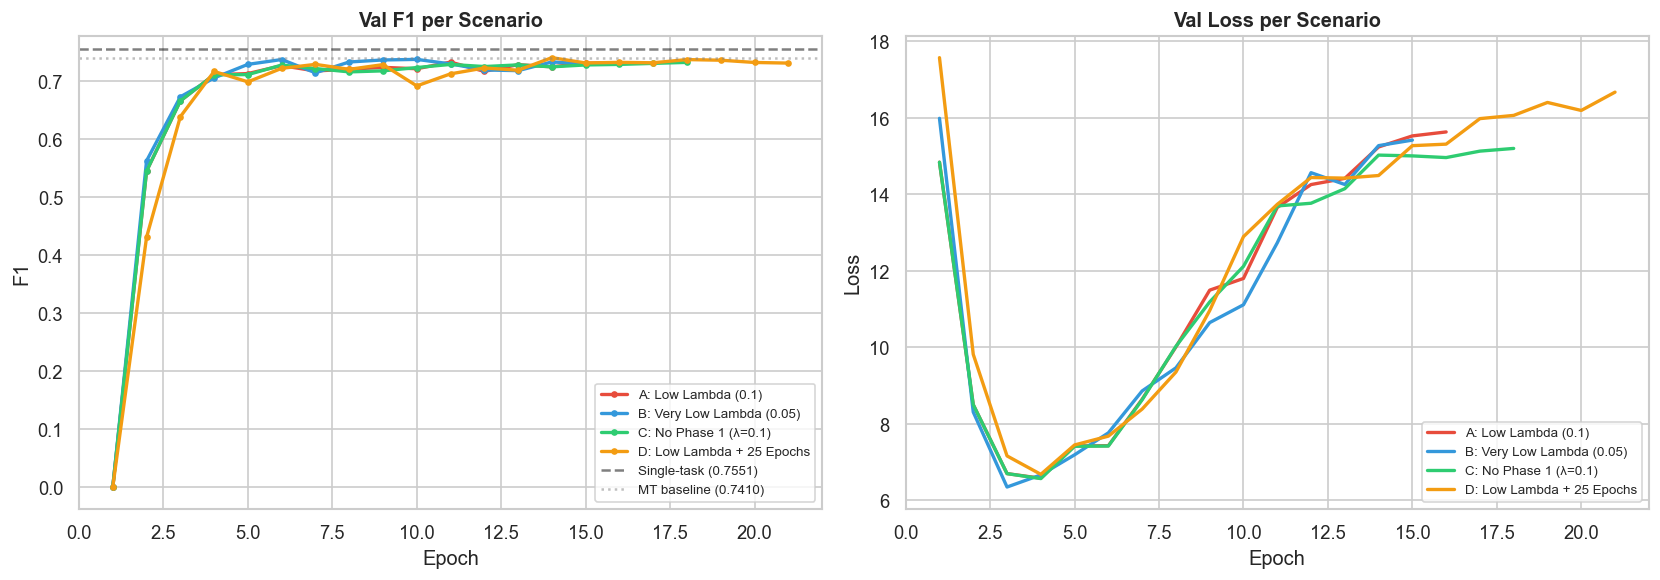

In [10]:
n_scenarios = len(all_results)
if n_scenarios > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

    for i, r in enumerate(all_results):
        epochs = range(1, len(r['history']['val_f1']) + 1)
        c = colors[i % len(colors)]
        axes[0].plot(epochs, r['history']['val_f1'], label=r['name'],
                     linewidth=2, color=c, marker='o', markersize=3)
        axes[1].plot(epochs, r['history']['val_loss'], label=r['name'],
                     linewidth=2, color=c)

    # Reference lines
    axes[0].axhline(0.7551, color='black', linestyle='--', alpha=0.5, label='Single-task (0.7551)')
    axes[0].axhline(0.7410, color='gray', linestyle=':', alpha=0.5, label='MT baseline (0.7410)')

    axes[0].set_title('Val F1 per Scenario', fontweight='bold')
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('F1')
    axes[0].legend(fontsize=8)

    axes[1].set_title('Val Loss per Scenario', fontweight='bold')
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Loss')
    axes[1].legend(fontsize=8)

    plt.tight_layout()
    plt.show()
else:
    print('No results to visualize.')

### 10. SIMPAN HASIL

In [11]:
if len(all_results) > 0:
    checkpoint = {
        'scenarios': SCENARIOS,
        'results': all_results,
        'reference': REFERENCE,
        'best_scenario': best_scenario['name'] if best_scenario else None,
        'best_f1': best_scenario_f1,
        'base_config': {
            'model_name': MODEL_NAME,
            'dropout': DROPOUT,
            'weight_decay': WEIGHT_DECAY,
            'lr_bert': LR_BERT,
            'lr_head': LR_HEAD,
            'batch_size': BATCH_SIZE * GRADIENT_ACCUMULATION,
            'data': f'{len(raw_data)} samples, {TRAIN_RATIO*100:.0f}/{(1-TRAIN_RATIO)*100:.0f} split',
        },
    }

    save_path = os.path.join(MODEL_DIR, 'checkpoint_tuning_v2.pt')
    torch.save(checkpoint, save_path)

    file_size = os.path.getsize(save_path) / (1024**2)
    print(f'Checkpoint saved: {save_path}')
    print(f'File size: {file_size:.1f} MB')
    print(f'Best scenario: {best_scenario["name"]} (F1={best_scenario_f1:.4f})')
else:
    print('No results to save.')

Checkpoint saved: d:\Kuliah\TA\Notebook\models\checkpoint_tuning_v2.pt
File size: 0.2 MB
Best scenario: D: Low Lambda + 25 Epochs (F1=0.7409)
